<a href="https://colab.research.google.com/github/TanyaYadav/Deep-Learning-Projects/blob/main/Human_Activity_Recognition_using_LSTM_%26_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###***importing the libraries***

In [ ]:
# To discard the output of this cell
%%capture

!pip install pafy youtube-dl moviepy

In [ ]:
import os
import cv2
import pafy
import math
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque
from moviepy.editor import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model

In [ ]:
import random
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

###***Download & visualize the data with its labels***

In [ ]:
%%capture

# Downloading UCF50 dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

!unrar x UCF50.rar

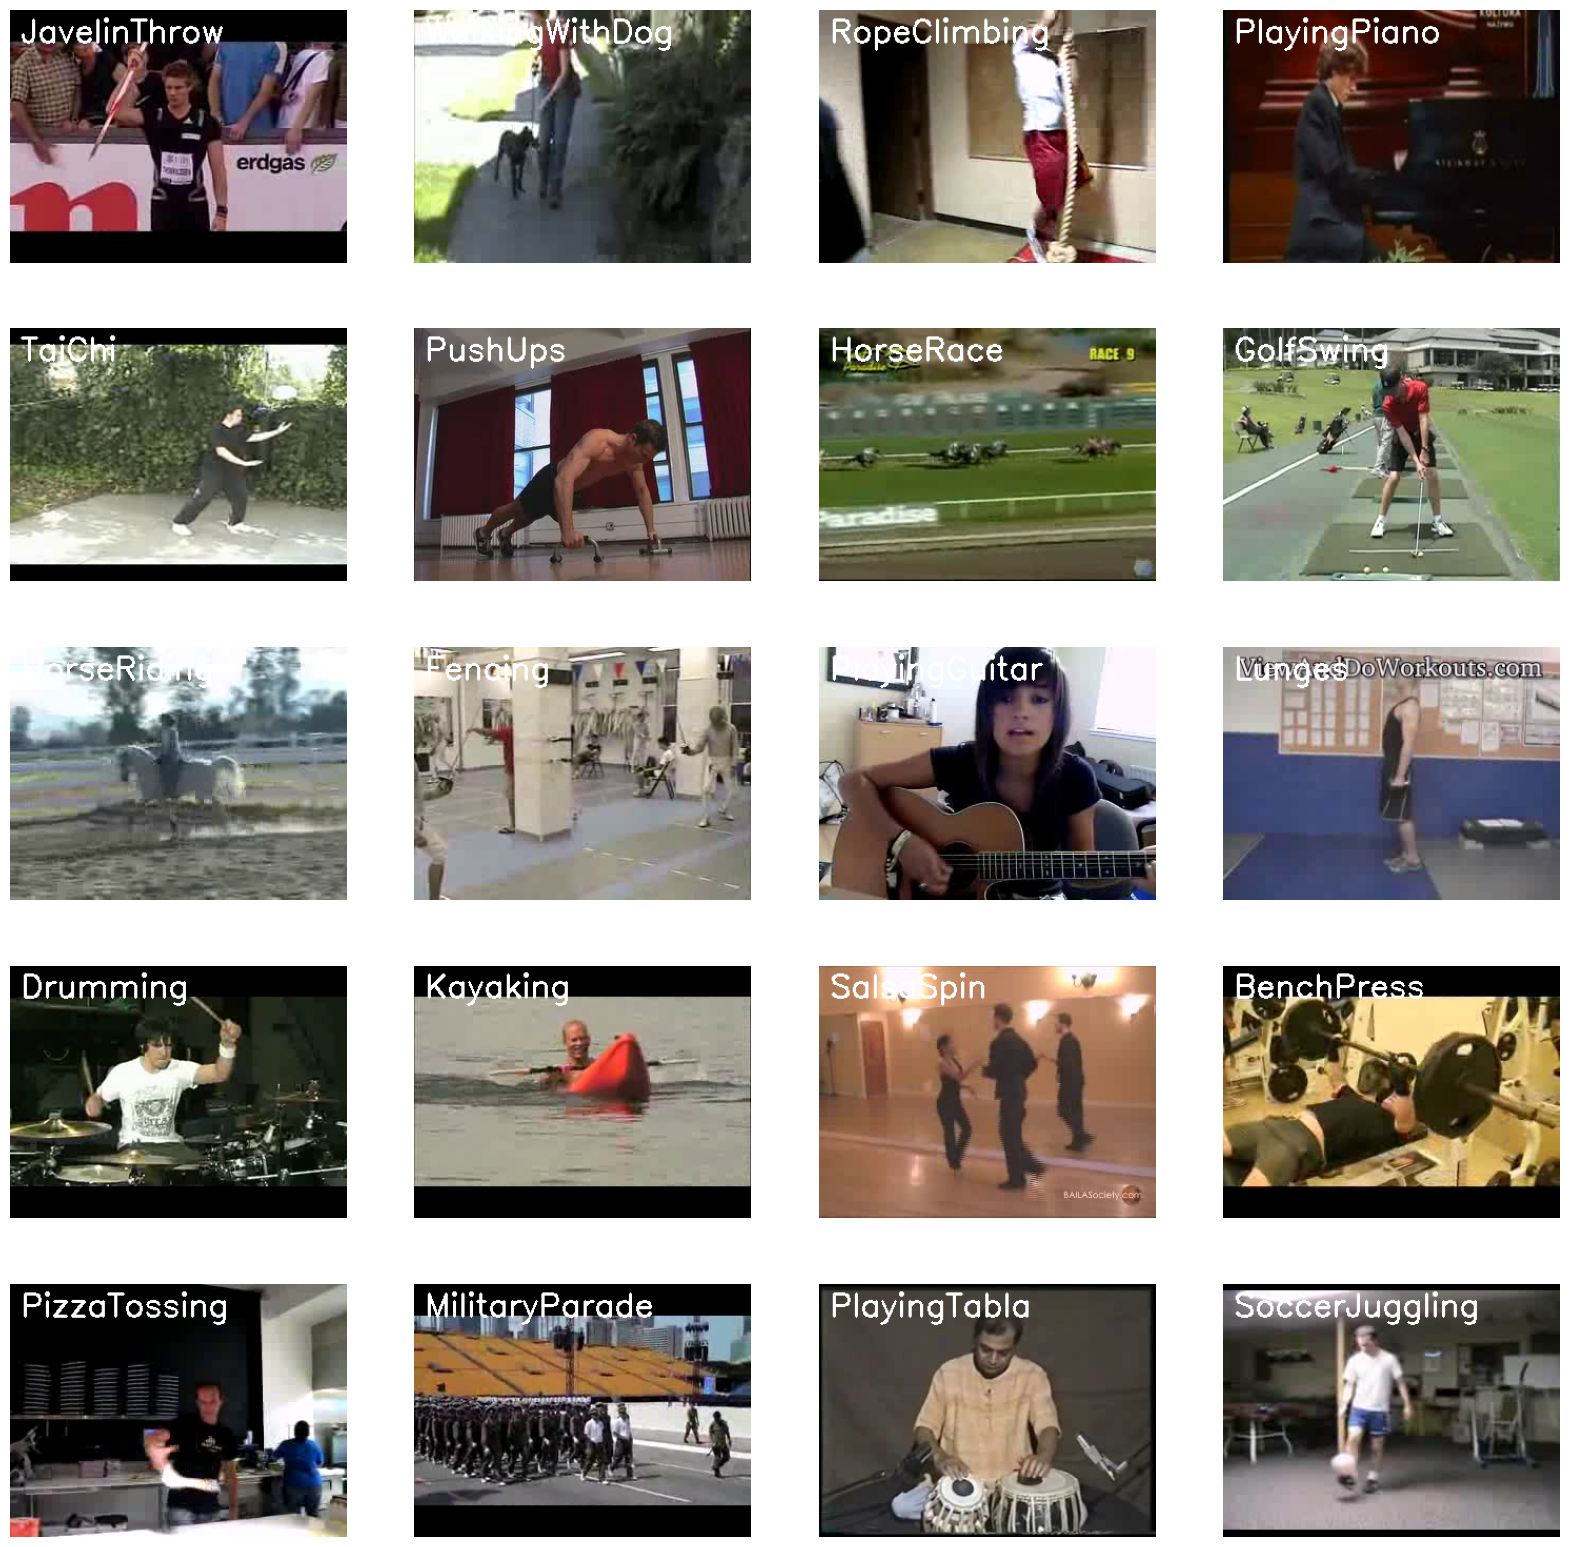

In [ ]:
plt.figure(figsize=(20,20))
all_classes_names = os.listdir('/content/UCF50')
random_range = random.sample(range(len(all_classes_names)), 20)
for counter, random_index in enumerate(random_range):
  selected_class = all_classes_names[random_index]
  video_files_names_list = os.listdir(os.path.join('/content/UCF50',selected_class))
  random_video_file_name = random.choice(video_files_names_list)
  video_cap = cv2.VideoCapture(os.path.join('/content/UCF50',selected_class,random_video_file_name))
  ret, frame = video_cap.read()
  video_cap.release()
  rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame, selected_class, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
  plt.subplot(5,4,counter+1)
  plt.imshow(rgb_frame)
  plt.axis('off')



###***Preprocessing the dataset***

In [ ]:
img_height, img_width = 64, 64
sequence_length = 20
dataset_dir = '/content/UCF50'
classes_list = ['WalkingWithDog', 'TaiChi', 'Swing', 'HorseRace']

####***Extracting, resizing and normalizing frames***

In [ ]:
def frames_extraction(video_path):
  frames_list = []
  video_cap = cv2.VideoCapture(video_path)
  video_frames_count = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/sequence_length),1)
  for frame_counter in range(sequence_length):
    video_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_counter*skip_frames_window)
    success, frame = video_cap.read()
    if not success:
      break
    resized_frame = cv2.resize(frame, (img_height, img_width))
    normalized_frame = resized_frame/255
    frames_list.append(normalized_frame)
  video_cap.release()
  return frames_list



###***Creation of dataset***

In [ ]:
def create_dataset():

  features = []
  labels = []
  video_file_paths = []

  for class_idx, class_name in enumerate(classes_list):
    print(f'Extracting data of class ', {class_name})
    files_list = os.listdir(os.path.join(dataset_dir, class_name))
    for file_name in files_list:
      video_file_path = os.path.join(dataset_dir, class_name, file_name)
      frames = frames_extraction(video_file_path)
      if len(frames)==sequence_length:
        features.append(frames)
        labels.append(class_idx)
        video_file_paths.append(video_file_path)

  features = np.asarray(features)
  labels = np.array(labels)
  return features, labels, video_file_paths

In [ ]:
features, labels, video_file_paths = create_dataset()

Extracting data of class  {'WalkingWithDog'}
Extracting data of class  {'TaiChi'}
Extracting data of class  {'Swing'}
Extracting data of class  {'HorseRace'}


In [ ]:
one_hot_encoded_labels = to_categorical(labels)
print(one_hot_encoded_labels)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


###***Split the data into training and testing set***

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle=True, random_state=seed_constant)

###***Implementing the ConvLSTM approach***

In [ ]:
def create_convlstm_model():
  model = Sequential()

  model.add(ConvLSTM2D(filters=4, kernel_size=(3,3), activation='tanh', data_format='channels_last',
                       recurrent_dropout=0.2, return_sequences=True, input_shape=(sequence_length, img_height, img_width, 3)))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=8, kernel_size=(3,3), activation='tanh', data_format='channels_last',
                       recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=14, kernel_size=(3,3), activation='tanh', data_format='channels_last',
                       recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=16, kernel_size=(3,3), activation='tanh', data_format='channels_last',
                       recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))

  model.add(Flatten())
  model.add(Dense(len(classes_list), activation='softmax'))

  model.summary()

  return model

In [ ]:
convlstm_model = create_convlstm_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

###***check model's architecture***

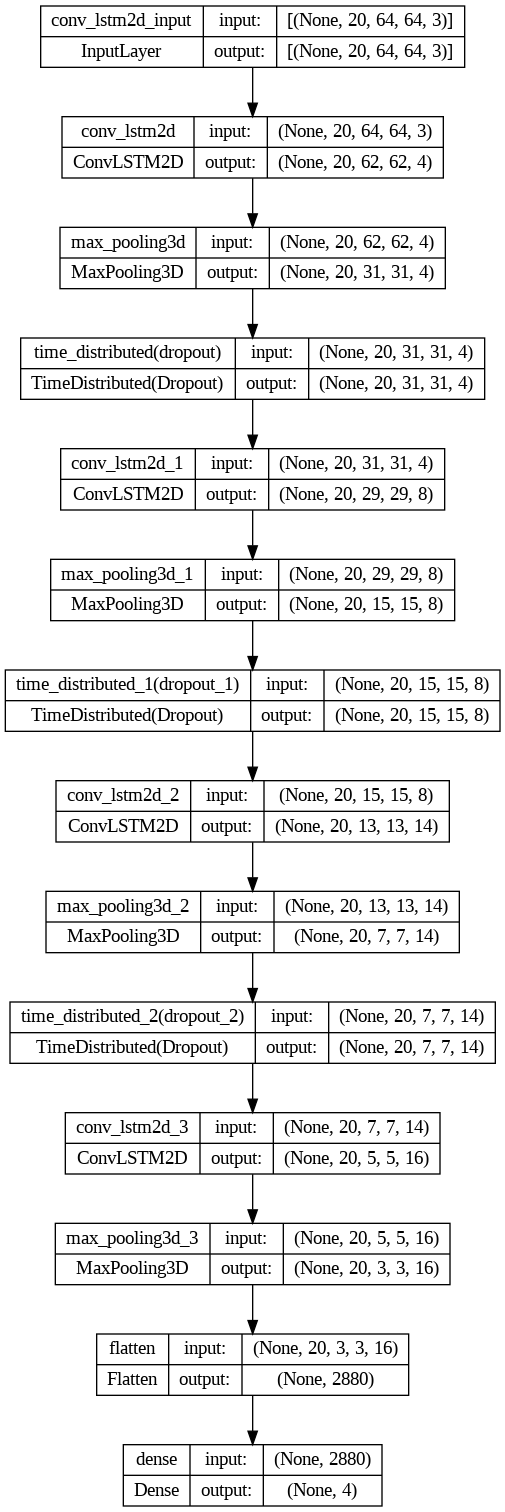

In [ ]:
plot_model(convlstm_model, to_file='convlstm_model_structure.png', show_shapes=True, show_layer_names=True)

###***Compile & train the model***

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
convlstm_model_history = convlstm_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
73/73 [==============================] - 26s 236ms/step - loss: 0.6347 - accuracy: 0.7432 - val_loss: 1.0700 - val_accuracy: 0.6301
Epoch 2/50
73/73 [==============================] - 17s 232ms/step - loss: 0.4971 - accuracy: 0.8185 - val_loss: 1.0188 - val_accuracy: 0.5890
Epoch 3/50
73/73 [==============================] - 18s 243ms/step - loss: 0.3792 - accuracy: 0.8288 - val_loss: 1.2136 - val_accuracy: 0.6164
Epoch 4/50
73/73 [==============================] - 16s 221ms/step - loss: 0.2829 - accuracy: 0.9041 - val_loss: 0.9046 - val_accuracy: 0.6986
Epoch 5/50
73/73 [==============================] - 16s 219ms/step - loss: 0.2740 - accuracy: 0.8870 - val_loss: 0.8141 - val_accuracy: 0.7260
Epoch 6/50
73/73 [==============================] - 16s 219ms/step - loss: 0.1944 - accuracy: 0.9247 - val_loss: 0.9738 - val_accuracy: 0.7123
Epoch 7/50
73/73 [==============================] - 17s 238ms/step - loss: 0.0832 - accuracy: 0.9829 - val_loss: 1.0962 - val_accuracy: 0.6849

In [ ]:
convlstm_model.save('convlstm_human_activity.h5')

###***Evaluating the model on test data***

In [ ]:
convlstm_model.evaluate(features_test,labels_test )

4/4 [==============================] - 1s 128ms/step - loss: 0.7820 - accuracy: 0.7377


[0.7820468544960022, 0.7377049326896667]

###***Implementing LRCN approach***

In [ ]:
def LRCN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'),
                                   input_shape=(sequence_length, img_height, img_width, 3)))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))

  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(Dense(len(classes_list), activation='softmax'))
  model.summary()
  return model




In [ ]:
lrcn_model = LRCN()

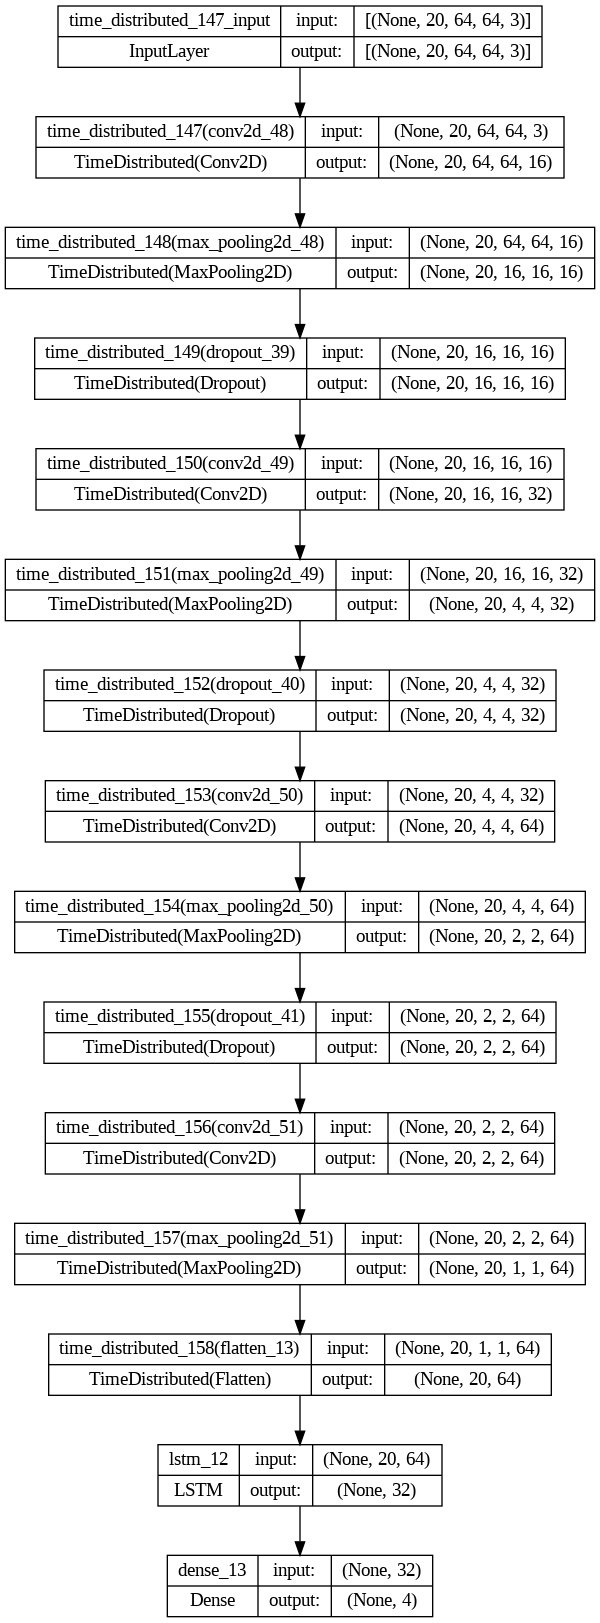

In [ ]:
plot_model(lrcn_model, to_file='lrcn_model_structure.png', show_shapes=True, show_layer_names=True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
lrcn_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
lrcn_model_history = lrcn_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
73/73 [==============================] - 7s 24ms/step - loss: 1.3882 - accuracy: 0.2877 - val_loss: 1.3696 - val_accuracy: 0.4247
Epoch 2/50
73/73 [==============================] - 1s 13ms/step - loss: 1.2909 - accuracy: 0.4007 - val_loss: 1.3168 - val_accuracy: 0.3288
Epoch 3/50
73/73 [==============================] - 1s 13ms/step - loss: 1.1108 - accuracy: 0.5205 - val_loss: 1.0834 - val_accuracy: 0.5342
Epoch 4/50
73/73 [==============================] - 1s 14ms/step - loss: 0.9280 - accuracy: 0.6267 - val_loss: 1.0962 - val_accuracy: 0.5205
Epoch 5/50
73/73 [==============================] - 1s 12ms/step - loss: 0.8436 - accuracy: 0.6370 - val_loss: 0.8862 - val_accuracy: 0.6301
Epoch 6/50
73/73 [==============================] - 1s 11ms/step - loss: 0.7245 - accuracy: 0.7192 - val_loss: 1.0111 - val_accuracy: 0.5616
Epoch 7/50
73/73 [==============================] - 1s 10ms/step - loss: 0.6067 - accuracy: 0.7637 - val_loss: 0.8150 - val_accuracy: 0.6849
Epoch 8/50
73

In [ ]:
lrcn_model.save('lrcn_human_activity.h5')

In [ ]:
lrcn_model.evaluate(features_test,labels_test )

4/4 [==============================] - 1s 80ms/step - loss: 0.4967 - accuracy: 0.8361


[0.4966733455657959, 0.8360655903816223]

###***Download youtube videos***

In [ ]:
import yt_dlp as youtube_dl

In [ ]:
def download_youtube_videos(youtube_video_url, output_dir):
  video = pafy.new(youtube_video_url)
  title = video.title
  video_best = video.getbest()
  output_file_path = f'{output_dir}/{title}.mp4'
  video_best.download(filepath=output_file_path, quiet=True)
  return title


In [ ]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok=True)
video_title = download_youtube_videos('https://www.youtube.com/watch?v=F0uCFLriI0Q',test_videos_directory)
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'



In [ ]:
# !pip install --force-reinstall https://github.com/yt-dlp/yt-dlp/archive/master.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/yt-dlp/yt-dlp/archive/master.tar.gz (2.4 MB)
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user


In [ ]:
# !pip install git+https://github.com/Cupcakus/pafy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Cupcakus/pafy to /tmp/pip-req-build-qc_w1_29
  Running command git clone --filter=blob:none --quiet https://github.com/Cupcakus/pafy /tmp/pip-req-build-qc_w1_29
  Resolved https://github.com/Cupcakus/pafy to commit 45f0deb067bf7c420cdf83a0529fd5274c12de18
  Preparing metadata (setup.py) ... done
  Created wheel for pafy: filename=pafy-0.5.5-py2.py3-none-any.whl size=35743 sha256=f80ca02be95351c2f1c97451ecbdae7fa4db9a13a1c5d3fd350c1c4e53031f1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-fpdoj51w/wheels/f3/f3/22/2821d2011f946fbd644d6cfef96e8712ea9d4962dd3ac4d415
Successfully built pafy


###***Action recognition on Videos***

In [ ]:
lrcn_model = tf.keras.models.load_model('/content/drive/MyDrive/lrcn_human_activity.h5')

In [ ]:
def predict_on_videos(video_file_path, output_file_path, sequence_len):
  vid_cap = cv2.VideoCapture(video_file_path)
  original_video_width = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
  video_writer = cv2.VideoWriter(output_file_path, fourcc, vid_cap.get(cv2.CAP_PROP_FPS), (original_video_width,original_video_height ) )
  frames_queue = deque(maxlen=sequence_len)
  predicted_class_name = ''
  while vid_cap.isOpened():
    ok, frame = vid_cap.read()
    if not ok:
      break
    resized_frame = cv2.resize(frame, (img_height, img_width))
    normalized_frame = resized_frame/255
    frames_queue.append(normalized_frame)

    if len(frames_queue)==sequence_len:
      predict_label_probabilities = lrcn_model.predict(np.expand_dims(frames_queue, axis=0))[0]
      predicted_label = np.argmax(predict_label_probabilities)
      predicted_class_name = classes_list[predicted_label]
    cv2.putText(frame, predicted_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    video_writer.write(frame)

  video_writer.release()
  vid_cap.release()

In [ ]:
output_video_path = f'{test_videos_directory}/{video_title}-Output_seqlen{sequence_length}.mp4'
predict_on_videos(input_video_file_path ,output_video_path, sequence_length)


1/1 [==============================] - 0s 31ms/step


In [1]:
# VideoFileClip(output_video_path,target_resolution=(300, None)).ipython_display()